# Market Snapshot: 10-Year Performance of Major Assets

This notebook analyzes returns and risk across major asset classes
over the last decade.

Assets:
- S&P 500 (SPY)
- Nasdaq 100 (QQQ)
- Long-Term Bonds (TLT)
- Gold (GLD)
- Bitcoin (BTC-USD)


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

plt.style.use("seaborn-v0_8")

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)



In [19]:
tickers = ["SPY", "QQQ", "TLT", "GLD", "BTC-USD"]

prices = yf.download(
    tickers,
    start ="2014-01-01",
    auto_adjust=True,
    progress=False,
)["Close"]

prices.head()

Ticker,BTC-USD,GLD,QQQ,SPY,TLT
Date,,,,,
2014-01-02,NaN,118.000000,79.143295,148.986038,73.843132
2014-01-03,NaN,119.290001,78.571968,148.961639,73.843132
2014-01-06,NaN,119.500000,78.281769,148.529907,74.153870
2014-01-07,NaN,118.820000,79.007286,149.442169,74.341766
2014-01-08,NaN,118.120003,79.179573,149.474701,74.139427


In [20]:
# --- Cell 3: If BTC is still broken, try re-downloading BTC alone and merge ---
# (This handles occasional Yahoo partial failures for BTC in multi-ticker requests.)

if "BTC-USD" in prices.columns and prices["BTC-USD"].isna().all():
    btc = yf.download(
        "BTC-USD",
        start="2014-01-01",
        auto_adjust=True,
        progress=False,
        threads=False,
    )["Close"].rename("BTC-USD")

    prices = prices.drop(columns=["BTC-USD"])
    prices = prices.join(btc, how="outer").sort_index()
    prices = prices.dropna(how="all").ffill().dropna(how="all")

print("NaNs per ticker after BTC fix:\n", prices.isna().sum())
prices.tail()


NaNs per ticker after BTC fix:
 Ticker
BTC-USD     178
GLD        1283
QQQ        1283
SPY        1283
TLT        1283
dtype: int64


Ticker,BTC-USD,GLD,QQQ,SPY,TLT
Date,,,,,
2025-12-23,87414.000000,413.640015,622.109985,687.960022,87.500000
2025-12-24,87611.960938,411.929993,623.929993,690.380005,88.029999
2025-12-25,87234.742188,NaN,NaN,NaN,NaN
2025-12-26,87301.429688,416.739990,623.890015,690.309998,87.739998
2025-12-27,87513.281250,NaN,NaN,NaN,NaN


In [21]:
# --- Cell 4: Returns ---
returns = prices.pct_change().dropna()
returns.head()


/var/folders/7g/npmf5hmj4yn1rb98fd9wwl9c0000gn/T/ipykernel_81606/430901987.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna()


Ticker,BTC-USD,GLD,QQQ,SPY,TLT
Date,,,,,
2014-09-18,-0.071926,0.002042,0.007535,0.005330,0.003192
2014-09-19,-0.069843,-0.005858,-0.000620,-0.000901,0.012725
2014-09-20,0.035735,0.000000,0.000000,0.000000,0.000000
2014-09-21,-0.024659,0.000000,0.000000,0.000000,0.000000
2014-09-22,0.008352,-0.002050,-0.009302,-0.007723,0.001221


In [22]:
# --- Cell 5: Robust metrics (CAGR, Vol, Max Drawdown) ---
def cagr(series: pd.Series) -> float:
    s = series.dropna()
    if len(s) < 2:
        return np.nan
    years = (s.index[-1] - s.index[0]).days / 365.25
    if years <= 0:
        return np.nan
    return (s.iloc[-1] / s.iloc[0]) ** (1 / years) - 1

def max_drawdown(series: pd.Series) -> float:
    s = series.dropna()
    if len(s) < 2:
        return np.nan
    dd = s / s.cummax() - 1
    return dd.min()

metrics = pd.DataFrame({
    "Start": prices.apply(lambda s: s.dropna().index[0] if s.dropna().size else pd.NaT),
    "End": prices.apply(lambda s: s.dropna().index[-1] if s.dropna().size else pd.NaT),
    "CAGR": prices.apply(cagr),
    "Volatility (ann.)": returns.std() * np.sqrt(252),
    "Max Drawdown": prices.apply(max_drawdown),
}).sort_values("CAGR", ascending=False)

metrics



,Start,End,CAGR,Volatility (ann.),Max Drawdown
Ticker,,,,,
BTC-USD,2014-09-17,2025-12-27,0.593459,0.558703,-0.833990
QQQ,2014-01-02,2025-12-26,0.188075,0.181383,-0.351187
SPY,2014-01-02,2025-12-26,0.136528,0.146966,-0.337173
GLD,2014-01-02,2025-12-26,0.111062,0.122925,-0.244929
TLT,2014-01-02,2025-12-26,0.014497,0.124251,-0.483511


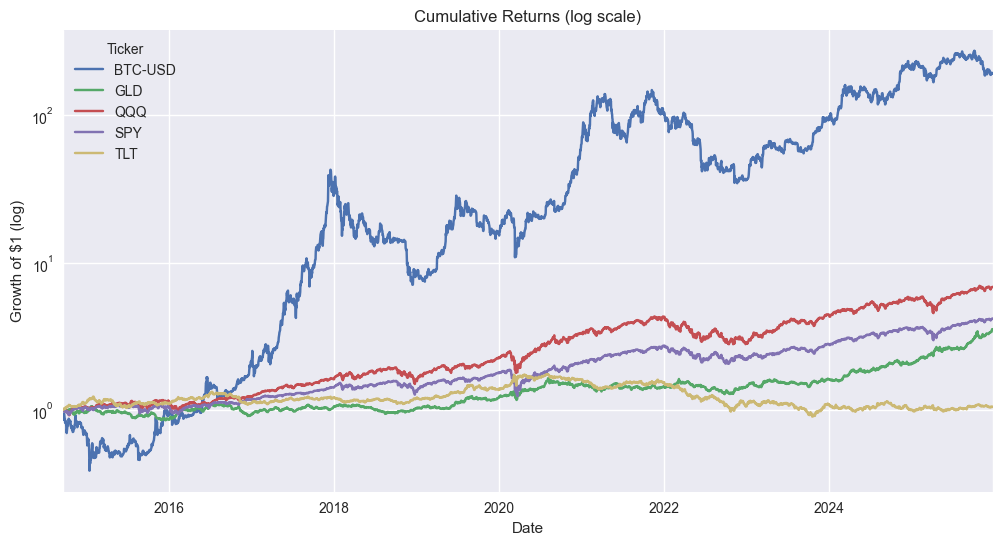

In [25]:
# --- Cell 6: Cumulative returns plot ---
cum = (1 + returns).cumprod()

ax = cum.plot(figsize=(12,6))
ax.set_yscale("log")
ax.set_title("Cumulative Returns (log scale)")
ax.set_ylabel("Growth of $1 (log)")
plt.show()

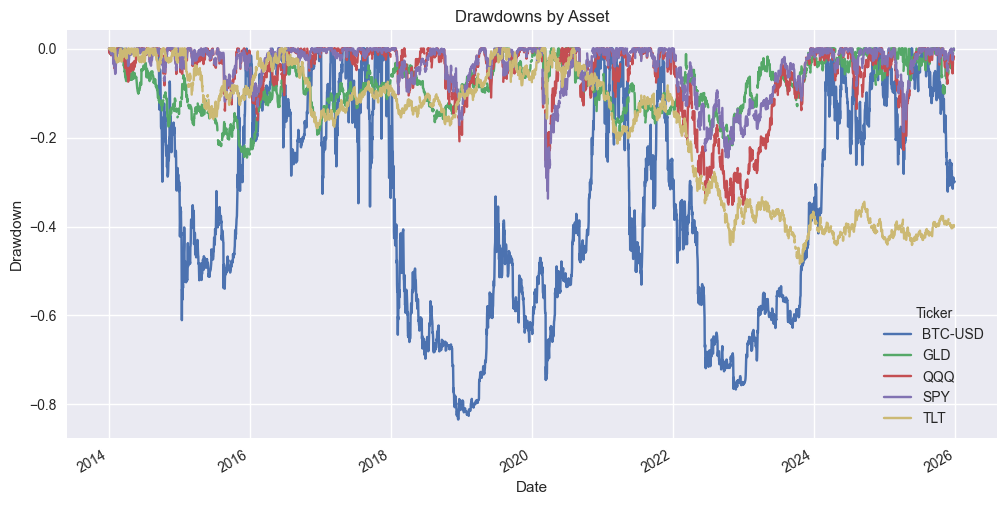

In [24]:
# --- Cell 7: Drawdown plot ---
drawdowns = prices / prices.cummax() - 1
ax = drawdowns.plot()
ax.set_title("Drawdowns by Asset")
ax.set_ylabel("Drawdown")
plt.show()



## Observations

- Equities delivered the highest long-term returns but with deep drawdowns
- Bitcoin dominates upside but with extreme volatility
- Bonds and gold reduced drawdowns during stress periods
- Risk-adjusted returns matter more than raw CAGR
